<a href="https://colab.research.google.com/github/VictorFBI/iad/blob/main/Frolov_Bukanov_Victor_hw08_boosting_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [2]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Сначала найдем признак, из-за которого возможен лик в данных и удалим его. Потом выполним разделение выборки

Лик в данных бывает 3 видов:  
- Временной (когда используются данные, которые будут доступны только в будущем. Например, предсказание текущих продаж, опираясь на будущие). В данном случае это исключено, так как таких данных нет
- Прямой (когда используются данные, имеющие сильную корреляцию с целевой переменной). Это скорее наш случай. Похоже, что *salary* и *salary_in_usd* будут сильно коррелировать
- Кросс-валидационный (когда данные из одной выборки просачиваются в другую по ошибке разделения). Тоже не наш случай, так как функция *train_test_split* скорее всего работает без ошибок  

Таким образом, удостоверимся,  что *salary* и *salary_in_usd* сильно коррелируют. Может, найдем ещё какие-то сильно коррелирующие данные и удалим их

In [3]:
df_int64 = df.select_dtypes(include=['int64'])
df_int64.corr()

,work_year,salary,salary_in_usd,remote_ratio
work_year,1.000000,-0.094724,0.228290,-0.236430
salary,-0.094724,1.000000,-0.023676,0.028731
salary_in_usd,0.228290,-0.023676,1.000000,-0.064171
remote_ratio,-0.236430,0.028731,-0.064171,1.000000


Cтранно, но как будто связи между *salary* и *salary_in_usd* никакой и нет, однако все равно удалим этот признак и будем предсказывать только *salary_in_usd*. Тем более, курс валюты может меняться, так что в таком случае мы как бы обучим модель на текущем курсе, который был на момент составления датасета, что не очень верно. Потом, при необходимости, можно уже будет переводить полученный прогноз из долларов в любую другую валюту, в зависимости от актуального курса

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['salary_in_usd', 'salary'])
y = df['salary_in_usd']

# 0.8 for train, 0.2 for test and val together
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, random_state=42, train_size=0.8)
# both 0.5 to test and val. Totally, both 0.1 out of source dataset for test and val
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42, test_size=0.5)
X_train

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,EUR,ES,0,ES,M
485,2023,MI,FT,Research Scientist,USD,US,100,US,M
2177,2022,SE,FT,Data Analyst,USD,US,0,US,M
3305,2022,SE,FT,Data Engineer,USD,US,100,US,M
1769,2023,SE,FT,Data Engineer,USD,US,100,US,M
...,...,...,...,...,...,...,...,...,...
1130,2023,SE,FT,Machine Learning Engineer,USD,US,100,US,M
1294,2023,SE,FT,Data Analyst,USD,US,0,US,M
860,2023,EX,FT,Data Engineer,USD,US,100,US,M
3507,2021,MI,FT,Research Scientist,EUR,FR,50,FR,M


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE:  0.43919350275197666
RMSE:  47001.82657708389


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import time

params = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__gamma': [0, 0.1, 0.2]
}

xgb = XGBRegressor(objective='reg:squarederror')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_params = grid_search.best_params_
print('Best parameters found: ', best_params)

best_model = grid_search.best_estimator_

start_time = time.time()
y_test_pred = best_model.predict(X_test)
prediction_time = time.time() - start_time

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)
print('MAPE: ', mape_test)
print('RMSE: ', rmse_test)

Best parameters found:  {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Training time:  46.62158179283142
Prediction time:  0.008638143539428711
MAPE:  0.38470194276038067
RMSE:  45175.53571706928


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [7]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.0 MB/s eta 0:00:00


In [8]:
from catboost import CatBoostRegressor

params = {
    'regressor__depth': [3, 6, 9],  # глубина дерева
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'regressor__iterations': [100, 200, 300],  # количество итераций обучения
    'regressor__l2_leaf_reg': [1, 3, 5],  # коэффициент L2-регуляризации
    'regressor__random_seed': [42]  # случайное начальное значение для воспроизводимости
}

catboost = CatBoostRegressor()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_params = grid_search.best_params_
print('Best parameters found: ', best_params)

best_model = grid_search.best_estimator_

start_time = time.time()
y_test_pred = best_model.predict(X_test)
prediction_time = time.time() - start_time

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)
print('MAPE: ', mape_test)
print('RMSE: ', rmse_test)

Best parameters found:  {'regressor__depth': 3, 'regressor__iterations': 100, 'regressor__l2_leaf_reg': 1, 'regressor__learning_rate': 0.1, 'regressor__random_seed': 42}
Training time:  44.3821120262146
Prediction time:  0.008214950561523438
MAPE:  0.3804227595045162
RMSE:  45108.63518188385


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:40:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

В прошлых пунктах я использовал GridSearchCV, хоть это и немного противоречило условию, но зато такой подход более правильный, и к тому же мне не пришлось прописывать логику валидации вручную, GridSearchCV сделал это за меня. Теперь же, я напишу свою валидацию, использую валидационную выборку, извлеченную в начале ноутбука, так как GridSearchCV не может работать с объектом типа Pool. Он принимает только X и y - обучающую выборку и ответы на обучающей выборке соответственно, что не получится передавать в условиях данного задания

In [15]:
from catboost import Pool

params = {
    'depth': [3, 6, 9],  # глубина дерева
    'learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'iterations': [100, 200, 300],  # количество итераций обучения
    'l2_leaf_reg': [1, 3, 5],  # коэффициент L2-регуляризации
    'random_seed': [42]  # случайное начальное значение для воспроизводимости
}

catboost = CatBoostRegressor()
train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)

best_error = float('+inf')
best_params = {}

start_time = time.time()
for depth in params['depth']:
  for learning_rate in params['learning_rate']:
    for iterations in params['iterations']:
      for l2_leaf_reg in params['l2_leaf_reg']:
        for random_seed in params['random_seed']:
          catboost = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, l2_leaf_reg=l2_leaf_reg, random_seed=random_seed)
          catboost.fit(train_data)
          curr_error = mean_squared_error(y_val, catboost.predict(X_val))
          if curr_error < best_error:
            best_error = curr_error
            best_model = catboost
            best_params = {
                'depth': depth,
                'learning_rate': learning_rate,
                'iterations': iterations,
                'l2_leaf_reg': l2_leaf_reg,
                'random_seed': random_seed
            }
training_time = time.time() - start_time

start_time = time.time()
y_test_pred = best_model.predict(X_test)
prediction_time = time.time() - start_time

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Best parameters found: ', best_params)
print('Training time: ', training_time)
print('Prediction time: ', prediction_time)
print('MAPE: ', mape_test)
print('RMSE: ', rmse_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
105:	learn: 50679.3929901	total: 3.87s	remaining: 3.44s
106:	learn: 50611.1261920	total: 3.9s	remaining: 3.39s
107:	learn: 50550.8754598	total: 3.92s	remaining: 3.34s
108:	learn: 50488.5774174	total: 3.96s	remaining: 3.31s
109:	learn: 50428.8668878	total: 3.99s	remaining: 3.26s
110:	learn: 50363.7524995	total: 4.01s	remaining: 3.22s
111:	learn: 50295.1754486	total: 4.04s	remaining: 3.17s
112:	learn: 50230.8910670	total: 4.06s	remaining: 3.13s
113:	learn: 50172.3473626	total: 4.08s	remaining: 3.08s
114:	learn: 50122.3115543	total: 4.11s	remaining: 3.04s
115:	learn: 50060.4480940	total: 4.15s	remaining: 3s
116:	learn: 50006.1220395	total: 4.18s	remaining: 2.96s
117:	learn: 49950.4116001	total: 4.21s	remaining: 2.92s
118:	learn: 49891.4290778	total: 4.24s	remaining: 2.89s
119:	learn: 49844.6377855	total: 4.26s	remaining: 2.84s
120:	learn: 49792.3208647	total: 4.29s	remaining: 2.8s
121:	learn: 49744.9296291	total: 4.32s	re

**Ответ:** время обучения, как и MAPE сильно возросло, что говорит об ухудшении показателей модели (если подождать лишние 160 секунд ещё можно, то мириться с возрастанием МАРЕ более чем на 6% не очень хочется). Однако время предсказания убыстрилось в 2 раза, но это вообще не ощущается, так как если раньше модель выдавала прогноз за 8 мс, то сейчас она выдает за 4 мс (примерно). В рамках таких маленьких единиц измерения, это разница вовсе неощутима, так что, выбирая из 1 и 2 модели, я скорее выберу вторую

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


Подберём гиперпараметры вновь используя GridSearchCV

In [13]:
from lightgbm import LGBMRegressor

params = {
    'regressor__max_depth': [3, 6, 9],  # глубина дерева
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # скорость обучения
    'regressor__n_estimators': [100, 200, 300],  # количество итераций обучения
    'regressor__num_leaves': [31, 50, 70],  # количество листьев в дереве
    'regressor__reg_lambda': [0, 0.1, 0.5]  # L2 регуляризация
}

lgbm = LGBMRegressor()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgbm)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_params = grid_search.best_params_
print('Best parameters found: ', best_params)

best_model = grid_search.best_estimator_

start_time = time.time()
y_test_pred = best_model.predict(X_test)
prediction_time = time.time() - start_time

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)
print('MAPE: ', mape_test)
print('RMSE: ', rmse_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 39
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**LGBM:**   
  
Best parameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__num_leaves': 31, 'regressor__reg_lambda': 0.5}  
Training time:  86.5280921459198  
Prediction time:  0.033746957778930664  
MAPE:  0.4223366248360908  
RMSE:  46190.282558302395  

**Catboost without Pool:**  
  
Best parameters found:  {'regressor__depth': 3, 'regressor__iterations': 100, 'regressor__l2_leaf_reg': 1, 'regressor__learning_rate': 0.1, 'regressor__random_seed': 42}  
Training time:  44.3821120262146  
Prediction time:  0.008214950561523438  
MAPE:  0.3804227595045162  
RMSE:  45108.63518188385  

**Catboost with Pool:**  
  
Best parameters found:  {'depth': 9, 'learning_rate': 0.05, 'iterations': 300, 'l2_leaf_reg': 1, 'random_seed': 42}  
Training time:  209.8765766620636  
Prediction time:  0.0031266212463378906  
MAPE:  0.44997901677781116  
RMSE:  46094.87642158586  
  

**Xgboost:**  
  
Best parameters found:  {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}  
Training time:  46.62158179283142  
Prediction time:  0.008638143539428711  
MAPE:  0.38470194276038067  
RMSE:  45175.53571706928  

Лучшая модель по качеству:  **Catboost without Pool**  
Лучшая модель по скорости обучения:  **Catboost without Pool**  
Лучшая модель по скорости предсказания: **Catboost with Pool**  
  
Короче, Яндекс опять круче всех  
Что касательно гиперпараметров, то они получились разные для разных моделей, но есть и сходства. Так, *learning_rate* равен 0.1 для 3 моделей из 4 (у **Catboost with Pool** он 0.05), максимaльная глубина (*max_depth* или *depth*) разная, но значение 3 встречается чаще всего (у **LGBM** и **Catboost without pool**), у **Catboost with pool** и **Xgboost** значения 9 и 5 соответственно. Также разные модели принимают разные гиперпараметры, так что некоторые показатели сравнить не получится. Однако нет особого смысла смотреть на эти показатели в отдельности, надо смотреть на всех них сразу и на ту модель, которая обучилась с этими гиперпараметрами, так как они взаимосвязаны между собой и напрямую влияют на качество конечной модели

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [16]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [17]:
ratings = ratings.transpose()
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [18]:
ratings = ratings.drop(['user'])
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [21]:
ratings.fillna(value=0, inplace=True)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
bob marleythe wailers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.070011,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(ratings)

labels = pd.DataFrame(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [30]:
labels.value_counts()

2    995
0      2
1      1
3      1
4      1
Name: count, dtype: int64

**Ответ:** конечно же такая кластеризация не несёт смысла, так как почти вся выборка попала в один кластер. Такой результат может быть по разным причинам. Одна из них - неверно подобранное число кластеров, но тут, кажется, проблема не в этом. Проблема тут скорее в том, что KMeans чувствителен к масштабу данных. Если признаки имеют разные масштабы, необходимо нормализовать или стандартизировать их перед кластеризацией, чего не было сделано перед процессом кластеризации, отчего и получился такой результат

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [37]:
ratings_copy = ratings.copy()
ratings_copy['cluster'] = kmeans.labels_

unique_clusters = ratings_copy['cluster'].value_counts()[ratings_copy['cluster'].value_counts() == 1].index

unique_indices = ratings_copy[ratings_copy['cluster'].isin(unique_clusters)].index
print(unique_indices.tolist())

['the beatles', 'coldplay', '보아']


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [42]:
# доля пользователей, которые слушают этого исполнителя
ratings_copy['user_percentage'] = ratings_copy.apply(lambda row: (row != 0).sum() / ratings_copy.shape[1], axis=1)
# средняя доля прослушивания
ratings_copy['average_listening_percentage'] = ratings_copy.apply(lambda row: row.sum(), axis=1)
ratings_copy

,0,1,2,3,4,5,6,7,8,9,...,4993,4994,4995,4996,4997,4998,4999,cluster,user_percentage,average_listening_percentage
the beatles,0.000000,0.000000,0.000000,0.0,0.043529,0.000000,0.0,0.0,0.093398,0.017621,...,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.000000,3,0.334599,95.198510
radiohead,0.020417,0.184962,0.000000,0.0,0.086281,0.006322,0.0,0.0,0.000000,0.019156,...,0.000000,0.011187,0.000000,0.0,0.000000,0.0,0.000000,2,0.278233,61.546608
deathcab for cutie,0.000000,0.024561,0.028635,0.0,0.034590,0.000000,0.0,0.0,0.000000,0.013349,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.027893,2,0.186688,34.910354
coldplay,0.000000,0.000000,0.000000,0.0,0.016712,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4,0.168699,34.327464
modest mouse,0.000000,0.000000,0.000000,0.0,0.015935,0.000000,0.0,0.0,0.000000,0.030437,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2,0.163302,31.550893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2,0.009994,6.488251
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2,0.009994,4.605347
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2,0.009994,6.998571
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2,0.009994,4.165599


Я создал две дополнительные колонки: user_percentage - доля пользователей, слушающих данного исполнителя, и average_listening_percentage - доля прослушивания этого исполнителя всеми пользователями. По этим двум показателям видна полная доминация группы The Beatles над остальными исполнителями, что и объясняет выделение этой группы в отдельный кластер. Чуть менее сильно, но группа Coldplay также выделяется по этим показателям, что также объясняет её выделение в отдельный кластер

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [118]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, norm='l2')
ratings_normalized = pd.DataFrame(ratings_normalized)
ratings_normalized.index = ratings.index
ratings_normalized

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [119]:
kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(ratings_normalized)

pd.DataFrame(kmeans.labels_).value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2    405
0    237
1    152
3    139
4     67
Name: count, dtype: int64

**Ответ** стало определенно лучше, теперь кластеризация имеет какой-то смысл

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [120]:
from sklearn.metrics.pairwise import cosine_similarity

centroids = kmeans.cluster_centers_

distances = cosine_similarity(ratings_normalized, centroids)

for cluster_idx in range(5):
    cluster_distances = distances[:, cluster_idx]
    top_indices = np.argsort(cluster_distances)[::-1][:10]  # индексы топ-10 исполнителей
    top_artists = ratings_normalized.iloc[top_indices].index.tolist()
    print(f"Cluster {cluster_idx + 1}: Top-10 artists closest to centroid:")
    print(top_artists)
    print()

Cluster 1: Top-10 artists closest to centroid:
['radiohead', 'the arcade fire', 'broken social scene', 'animal collective', 'belle and sebastian', 'sufjan stevens', 'the shins', 'of montreal', 'the pixies', 'spoon']

Cluster 2: Top-10 artists closest to centroid:
['kelly clarkson', 'rihanna & jay-z', 'maroon5', 'the pussycat dolls', 'john mayer', 'alicia keys', 'lady gaga', 'beyoncé', 'coldplay', 'nelly furtado']

Cluster 3: Top-10 artists closest to centroid:
['the beatles', 'the rolling stones', 'led zeppelin.', 'pink fluid', 'acdc', 'metallica', 'radiohead', 'red hot clili peppers', 'the clash', 'queen']

Cluster 4: Top-10 artists closest to centroid:
['fall out boy', 'saosin', 'brand new', 'taking back sunday', 'blink-182', 'anberlin', 'the used', 'cartel', 'chiodos', 'new found glory']

Cluster 5: Top-10 artists closest to centroid:
['nas', 'jay-z', 'a tribe called quest', 'kanye west', "the roots featuring d'angelo", 'lupe the gorilla', 'gangstarr', 'murs and 9th wonder', 'little

**Ответ:** к сожалению, не все исполнители мне тут знакомы, но кластер 3 я четко могу проинтерпретировать - это самые известные и наверняка самые прослушиваемые исполнители (the beatles, the rolling stones, acdc, metallica и другие), которые представлены в сервисе. Наша кластеризация как раз нашла их и выделила в отдельный кластер

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

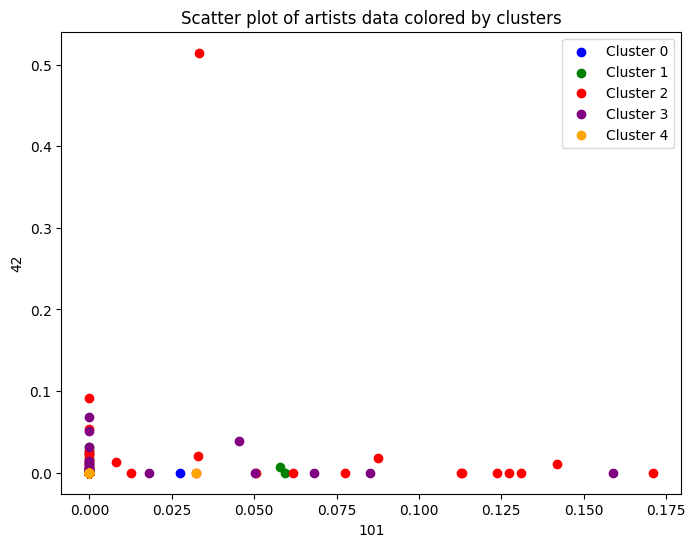

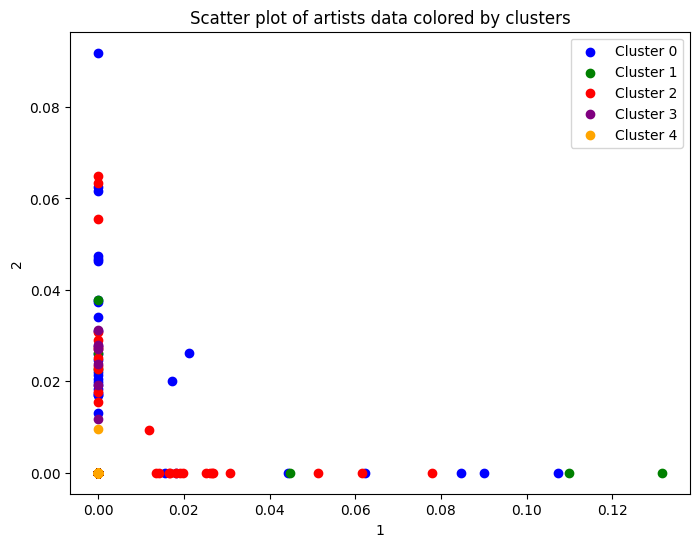

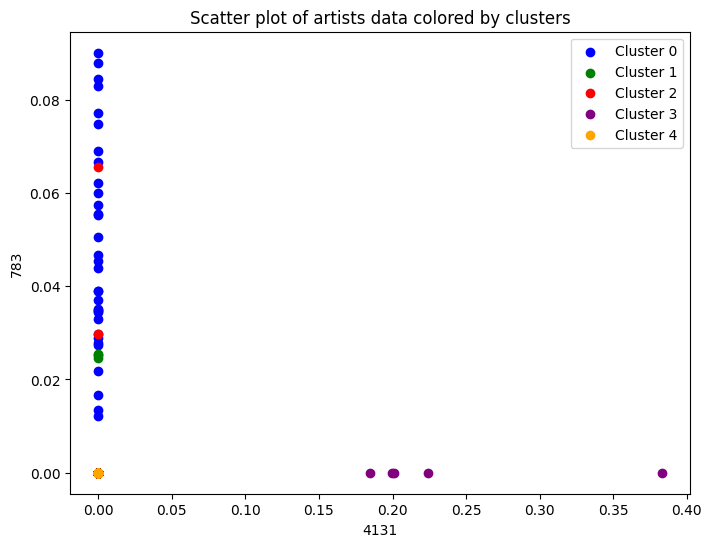

In [121]:
import matplotlib.pyplot as plt

# Цвета для кластеров
colors = ['blue', 'green', 'red', 'purple', 'orange']

ratings_normalized['cluster'] = kmeans.labels_

def plot_cluster_scatter(x, y, data, colors, ax):
    for cluster_id, color in enumerate(colors):
        cluster_data = data[data['cluster'] == cluster_id]
        ax.scatter(cluster_data[x], cluster_data[y], color=color, label=f'Cluster {cluster_id}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend()


fig, ax = plt.subplots(figsize=(8, 6))
plot_cluster_scatter(101, 42, ratings_normalized, colors, ax)
plt.title('Scatter plot of artists data colored by clusters')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plot_cluster_scatter(1, 2, ratings_normalized, colors, ax)
plt.title('Scatter plot of artists data colored by clusters')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plot_cluster_scatter(4131, 783, ratings_normalized, colors, ax)
plt.title('Scatter plot of artists data colored by clusters')
plt.show()


**Ответ:** может, я не так понял задание, но визуализации получились малоинформативными, по ним ничего непонятно. Возможно причина в том, что мы использовали только 2 признака для визуализации, а не их все, что слабо отражает реальную картину происходящего

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [122]:
ratings_normalized

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,cluster
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000,2
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000,0
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622,0
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2


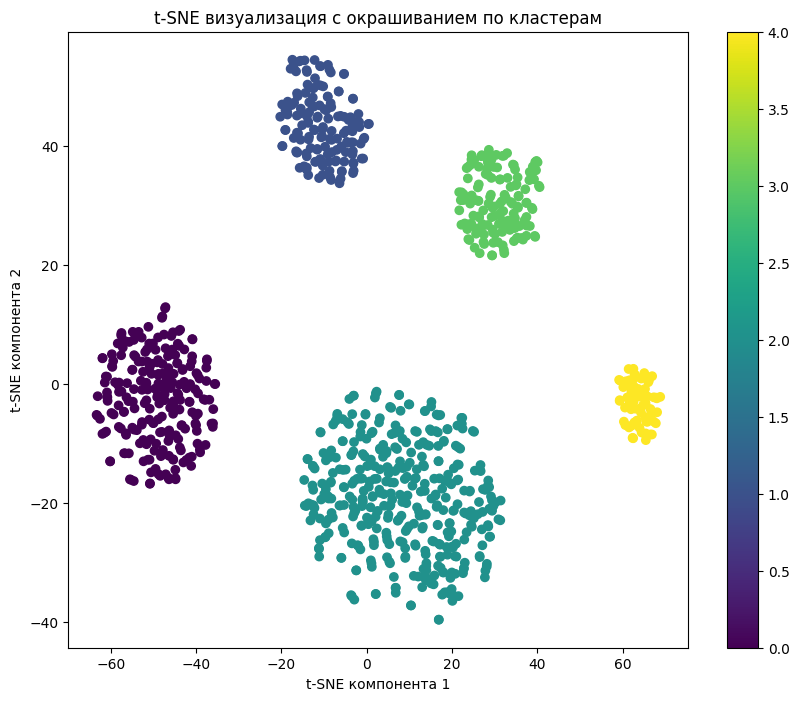

In [123]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
ratings_normalized.columns = ratings_normalized.columns.astype(str)
X_tsne = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ratings_normalized['cluster'], cmap='viridis')
plt.title('t-SNE визуализация с окрашиванием по кластерам')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [127]:
ratings_normalized.drop(columns=['cluster'], inplace=True)
ratings_normalized

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [132]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

min_clusters = 5
max_clusters = 100

for n_clusters in range(min_clusters, max_clusters + 1, 5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(ratings_normalized)
    # индекс Силуэта для текущего числа кластеров
    silhouette_avg = silhouette_score(ratings_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Оптимальное количество кластеров: 23
Значение Силуэта для оптимального числа кластеров: 0.015923489901689316


Последние 2 строчки выше остались с прошлого вывода, где ячейка ниже была в предыдущей ячейке. Подбор оптимального числа кластеров работал очень долго (около 4 минут), так что пересчитывать эту ячейку я не стал, оставив вывод таким. Правильный вывод находится в ячейке ниже

In [135]:
# оптимальное количество кластеров, дающее максимальное значение Силуэта
optimal_n_clusters = np.argmax(silhouette_scores) * 5 + min_clusters # np.argmax возвращает индекс максимального элемента в массиве

print(f"Оптимальное количество кластеров: {optimal_n_clusters}")
print(f"Значение Силуэта для оптимального числа кластеров: {silhouette_scores[(optimal_n_clusters - min_clusters) // 5]}")

Оптимальное количество кластеров: 95
Значение Силуэта для оптимального числа кластеров: 0.015923489901689316


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [137]:
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(ratings_normalized)

centroids = kmeans.cluster_centers_

distances = cosine_similarity(ratings_normalized, centroids)

for cluster_idx in range(optimal_n_clusters):
    cluster_distances = distances[:, cluster_idx]
    top_indices = np.argsort(cluster_distances)[::-1][:10]  # индексы топ-10 исполнителей
    top_artists = ratings_normalized.iloc[top_indices].index.tolist()
    print(f"Cluster {cluster_idx + 1}: Top-10 artists closest to centroid:")
    print(top_artists)
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1: Top-10 artists closest to centroid:
['circa survive', 'portugal. the man', 'cursive', 'citya and colour', 'the blood brothers', 'coheed and cambria', 'four year strong', 'owen', 'why?', 'manchester orchestra']

Cluster 2: Top-10 artists closest to centroid:
['the brian jonestown massacre', 'spiritualized®', 'black rebel motorcycle club', 'the dandy warhols', 'the verve', 'silver jews', 'pavement', 'the jesus and mary chain', 'velvet underground', 'sonic youth']

Cluster 3: Top-10 artists closest to centroid:
['squarepusher.', 'autechre', 'amon tobin', 'boards of canada', 'aphex twin', 'prefuse 73', 'underworld', 'rjd2', 'burial', 'björk guğmunsdóttir']

Cluster 4: Top-10 artists closest to centroid:
['talib kweli', "the roots featuring d'angelo", 'mos def', 'little brother', 'common', 'jurassic 5', 'cunninlynguists', 'lupe the gorilla', 'nas', 'a tribe called quest']

Cluster 5: Top-10 artists closest to centroid:
['mgmt', 'vampire weekend', 'tokyo police club', 'ratatat', '

**Ответ:** кластеров теперь стало очень много, зато кластеризация при этом стала точнее, а смысл кластеров при этом, естественно, изменился. Так, в кластере под номером 60, алгоритм выделил композиторов классической музыки ('Бах Иоганн Себастьян', 'ВИВАЛЬДИ', 'Вольфганг Амадей Моцарт', 'ШОПЕН', Эрик Сати ('Йrik satie')), а в кластере под номером 66 выделил музыкальные группы или дуэты, сочиняющие в стиле электронной музыки (the crystal method, the prodigy, the chemical brothers, Groove Armada)

Сделайте t-SNE визуализацию полученной кластеризации.

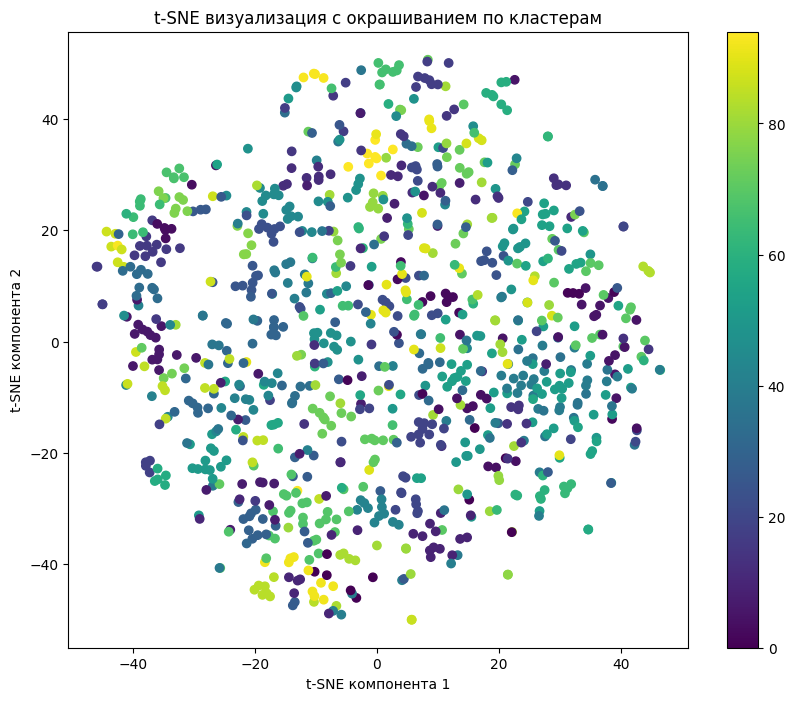

In [142]:
tsne = TSNE(n_components=2, random_state=42)
ratings_normalized.columns = ratings_normalized.columns.astype(str)
X_tsne = tsne.fit_transform(ratings_normalized)
ratings_normalized['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ratings_normalized['cluster'], cmap='viridis')
plt.title('t-SNE визуализация с окрашиванием по кластерам')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar()
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

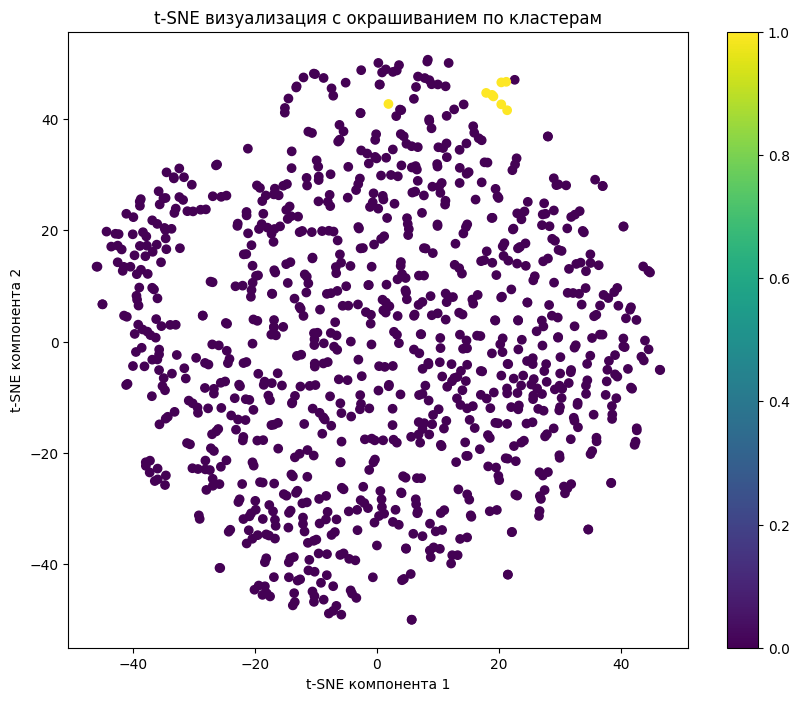

In [144]:
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=(ratings_normalized['cluster'] == 59), cmap='viridis')
# because from the beginning array was 0-indexed, then 60th cluster from the list above will be 59th in real
plt.title('t-SNE визуализация с окрашиванием по кластерам')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar()
plt.show()

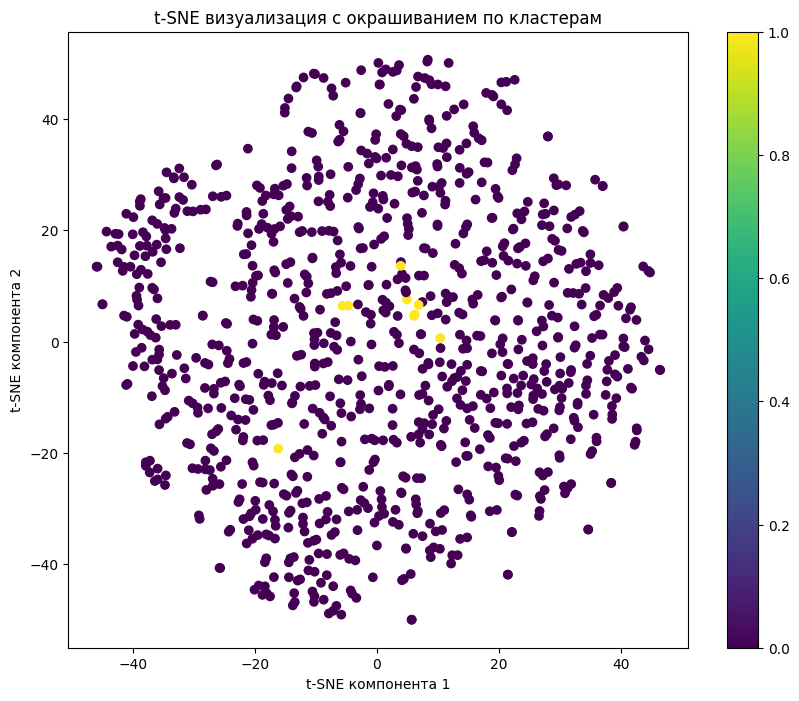

In [145]:
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=(ratings_normalized['cluster'] == 65), cmap='viridis') # analogously with 65 number
plt.title('t-SNE визуализация с окрашиванием по кластерам')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar()
plt.show()

**Ответ:** два рассмотренных мною кластера хорошо отображаются в визуализации: объекты, принадлежащие им, в большинстве своём сбиты в кучки, как и должно быть, но есть и некие выбросы, причём на каждой из визуализации, которые несложно отследить